In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #Til visualisering og seaborn
import seaborn as sns #for plotting - used for data visualisation
from sklearn.ensemble import RandomForestClassifier #Til modellen - teknisk set lidt snyd da det er randomforest
from sklearn.tree import DecisionTreeClassifier #Dokumentation: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#
from sklearn.tree import export_graphviz #Bruges til at eksportere til graphviz - til tree visualiseringen
from sklearn.metrics import roc_curve, auc #Til model evalution
from sklearn.metrics import classification_report #samme som ovenstående
from sklearn.metrics import confusion_matrix #samme
from sklearn.model_selection import train_test_split #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots
np.random.seed(123) #sætter NumPy's pseudo random number til 123 - vigtigt for at kunne genskabe resultatet. 

pd.options.mode.chained_assignment = None  #Får fejlbeskeder fra pandas og ved ikke hvorfor... så slår dem fra.

In [40]:
#Indlæs data
#hvis system sprog er dansk skal man benytte prefixet r for at specifere at det er raw string
dt = pd.read_csv(r"C:\Users\miboj\Documents\Data Science\Data\heart.csv")

In [41]:
dt.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


Data:
<br>
Data stammer fra UCI machine learning repository: https://archive.ics.uci.edu/ml/datasets/Heart+Disease
Data sættet indeholder 76 attributter, men kun 14 er medtaget i analysen.
<br>
<br>
Ordforklaring:
<br>
Hjertekrampe (angina pectoris) er smerte eller ubehag i brystkassen, der skyldes manglende ilttilførsel til hjertet.
ST-segmentet er den del af den samlede elektriske aktivitet, der befinder sig umiddelbart efter QRS indtil T-takken starter. Som udgangspunkt er ST-segmentet isoelektrisk (svarende til grundlinien) i et normalt overflade-ekg.
<br>
<br>
Forklaring af data:
<br>
cp: graden af bryst smerter (0 = typisk agina, 1 = atypisk agina, 2 = uspecificeret brystsmerte, 3 = ingen symptomer)
<br>
trestbps: Måling af dialogisk(hvilende) blodtryk ved indlæggelse
<br>
chol: kolestrol målt i mg/dl
<br>
fbs: Måling af om blodsukker i faste er over 120 mg/dl (1=True; 0=False)
<br>
restecg: elektrokardiogram (0 = normal, 1 = abnormale ST-T bølger, 2 = venstre ventrikulær hypertrofi)
<br>
thalach: patientes maxium hjerterytme
<br>
exang: angina fremprovokeret af træning (1 = ja, 0 = nej)
<br>
oldpeak: ST depresion
<br>
slope: hældningen på ST segment
<br>
ca: antallet af større blodkar farvet i fluoroskopi
<br>
thal: thallium stress test  (1 = normal, 2 = fixed defect, 3 = reversable defect)
<br>
target: Hjerte sygdom (0 = nej, 1 = ja)


Basis for modellen:
<br>
Modellen er evalueret efter risko grupperne fra: https://www.bhf.org.uk/informationsupport/risk-factors
<br>
Risiko grupper:
Højt kolesterol, højt blod tryk, diabetes, vægt, rygning, alder, arv, køn (mænd har højere risiko)
<br>
<br>
Inspiration/dokumentation:
<br>
Evaluating hyperparameters: https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6
<br>
Explain your model with SHAP: https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
<br>
Decision Trees in Machine Learning: https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052
<br>
Evaluating Machine Learning Classification Problems in Python: https://towardsdatascience.com/evaluating-machine-learning-classification-problems-in-python-5-1-metrics-that-matter-792c6faddf5
<br>
Dokumentation til SHAP: https://shap.readthedocs.io/en/latest/
<br>
Dokumentaion DecisionTreeClassifier: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#
<br>
Dokumentation Eli5: https://eli5.readthedocs.io/en/latest/overview.html

In [42]:
#Data vask - konvertering til et format der er nemmere at læse for mennesker
dt.columns = ['alder', 'køn', 'type_bryst_smerte', 'blodtryk_hvile', 'kolesterol', 'blodsukker_faste', 'ekg_hvile', 'max_hjerterytme',
    'angina_ved_træning', 'st_depresion','st_segment', 'blodkar_fluoroskopi', 'thallium_stress_test', 'target']
dt['køn'][dt['køn'] == 0] = 'kvinde'
dt['køn'][dt['køn'] == 1] = 'mand'

dt['type_bryst_smerte'][dt['type_bryst_smerte'] == 0] = 'typisk angina'
dt['type_bryst_smerte'][dt['type_bryst_smerte'] == 1] = 'atypisk angina'
dt['type_bryst_smerte'][dt['type_bryst_smerte'] == 2] = 'uspecificeret brystsmerte'
dt['type_bryst_smerte'][dt['type_bryst_smerte'] == 3] = 'ingen symptomer'

dt['blodsukker_faste'][dt['blodsukker_faste'] == 0] = 'under 120mg/ml'
dt['blodsukker_faste'][dt['blodsukker_faste'] == 1] = 'over 120mg/ml'

dt['ekg_hvile'][dt['ekg_hvile'] == 0] = 'normal'
dt['ekg_hvile'][dt['ekg_hvile'] == 1] = 'abnormal ST segment'
dt['ekg_hvile'][dt['ekg_hvile'] == 2] = 'venstre ventrikulær hypertrofi'

dt['angina_ved_træning'][dt['angina_ved_træning'] == 0] = 'nej'
dt['angina_ved_træning'][dt['angina_ved_træning'] == 1] = 'ja'

dt['st_segment'][dt['st_segment'] == 0] = 'eleveret'
dt['st_segment'][dt['st_segment'] == 1] = 'normal'
dt['st_segment'][dt['st_segment'] == 2] = 'sænket'

dt['thallium_stress_test'][dt['thallium_stress_test'] == 1] = 'normal'
dt['thallium_stress_test'][dt['thallium_stress_test'] == 2] = 'fixed defect'
dt['thallium_stress_test'][dt['thallium_stress_test'] == 3] = 'reversable defect'

dt.to_csv(r'C:\Users\miboj\Documents\Data Science\processed_data.csv')
del dt['blodkar_fluoroskopi'] #Dropper denne da den reelt ikke burde være med i en prediction model

In [43]:
dt.head(10)

,alder,køn,type_bryst_smerte,blodtryk_hvile,kolesterol,blodsukker_faste,ekg_hvile,max_hjerterytme,angina_ved_træning,st_depresion,st_segment,thallium_stress_test,target
0,63,mand,ingen symptomer,145,233,over 120mg/ml,normal,150,nej,2.3,eleveret,normal,1
1,37,mand,uspecificeret brystsmerte,130,250,under 120mg/ml,abnormal ST segment,187,nej,3.5,eleveret,fixed defect,1
2,41,kvinde,atypisk angina,130,204,under 120mg/ml,normal,172,nej,1.4,sænket,fixed defect,1
3,56,mand,atypisk angina,120,236,under 120mg/ml,abnormal ST segment,178,nej,0.8,sænket,fixed defect,1
4,57,kvinde,typisk angina,120,354,under 120mg/ml,abnormal ST segment,163,ja,0.6,sænket,fixed defect,1
5,57,mand,typisk angina,140,192,under 120mg/ml,abnormal ST segment,148,nej,0.4,normal,normal,1
6,56,kvinde,atypisk angina,140,294,under 120mg/ml,normal,153,nej,1.3,normal,fixed defect,1
7,44,mand,atypisk angina,120,263,under 120mg/ml,abnormal ST segment,173,nej,0.0,sænket,reversable defect,1
8,52,mand,uspecificeret brystsmerte,172,199,over 120mg/ml,abnormal ST segment,162,nej,0.5,sænket,reversable defect,1
9,57,mand,uspecificeret brystsmerte,150,168,under 120mg/ml,abnormal ST segment,174,nej,1.6,sænket,fixed defect,1


In [44]:
dt.dtypes

alder                     int64
køn                      object
type_bryst_smerte        object
blodtryk_hvile            int64
kolesterol                int64
blodsukker_faste         object
ekg_hvile                object
max_hjerterytme           int64
angina_ved_træning       object
st_depresion            float64
st_segment               object
thallium_stress_test     object
target                    int64
dtype: object

In [45]:
dt = pd.get_dummies(dt, drop_first=True) #Giver dummy værdier (1/0)

In [46]:
dt.head(10)

,alder,blodtryk_hvile,kolesterol,max_hjerterytme,st_depresion,target,køn_mand,type_bryst_smerte_ingen symptomer,type_bryst_smerte_typisk angina,type_bryst_smerte_uspecificeret brystsmerte,blodsukker_faste_under 120mg/ml,ekg_hvile_normal,ekg_hvile_venstre ventrikulær hypertrofi,angina_ved_træning_nej,st_segment_normal,st_segment_sænket,thallium_stress_test_fixed defect,thallium_stress_test_normal,thallium_stress_test_reversable defect
0,63,145,233,150,2.3,1,1,1,0,0,0,1,0,1,0,0,0,1,0
1,37,130,250,187,3.5,1,1,0,0,1,1,0,0,1,0,0,1,0,0
2,41,130,204,172,1.4,1,0,0,0,0,1,1,0,1,0,1,1,0,0
3,56,120,236,178,0.8,1,1,0,0,0,1,0,0,1,0,1,1,0,0
4,57,120,354,163,0.6,1,0,0,1,0,1,0,0,0,0,1,1,0,0
5,57,140,192,148,0.4,1,1,0,1,0,1,0,0,1,1,0,0,1,0
6,56,140,294,153,1.3,1,0,0,0,0,1,1,0,1,1,0,1,0,0
7,44,120,263,173,0.0,1,1,0,0,0,1,0,0,1,0,1,0,0,1
8,52,172,199,162,0.5,1,1,0,0,1,0,0,0,1,0,1,0,0,1
9,57,150,168,174,1.6,1,1,0,0,1,1,0,0,1,0,1,1,0,0


In [47]:
#Dokumentation for train_test_split https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train, X_test, y_train, y_test = train_test_split(dt.drop('target', 1), dt['target'], 
test_size = .2, random_state=10) #opdeler data i træning og test sæt




In [48]:
#Modellen virker både med RandomForestClassifier og DecisionTreeClassifier
#model = RandomForestClassifier(max_depth=4, n_estimators = 100)  #random forest
model = DecisionTreeClassifier(max_depth=150, criterion = "entropy")                     #decision tree
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=150, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [49]:
#estimator = model.estimators_[1] #Vælger en estimator som bliver visualiseret, n_estimators=100 som standard
estimator = model
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'ingen hjertesygdom'
y_train_str[y_train_str == '1'] = 'hjertesygdom'
y_train_str = y_train_str.values

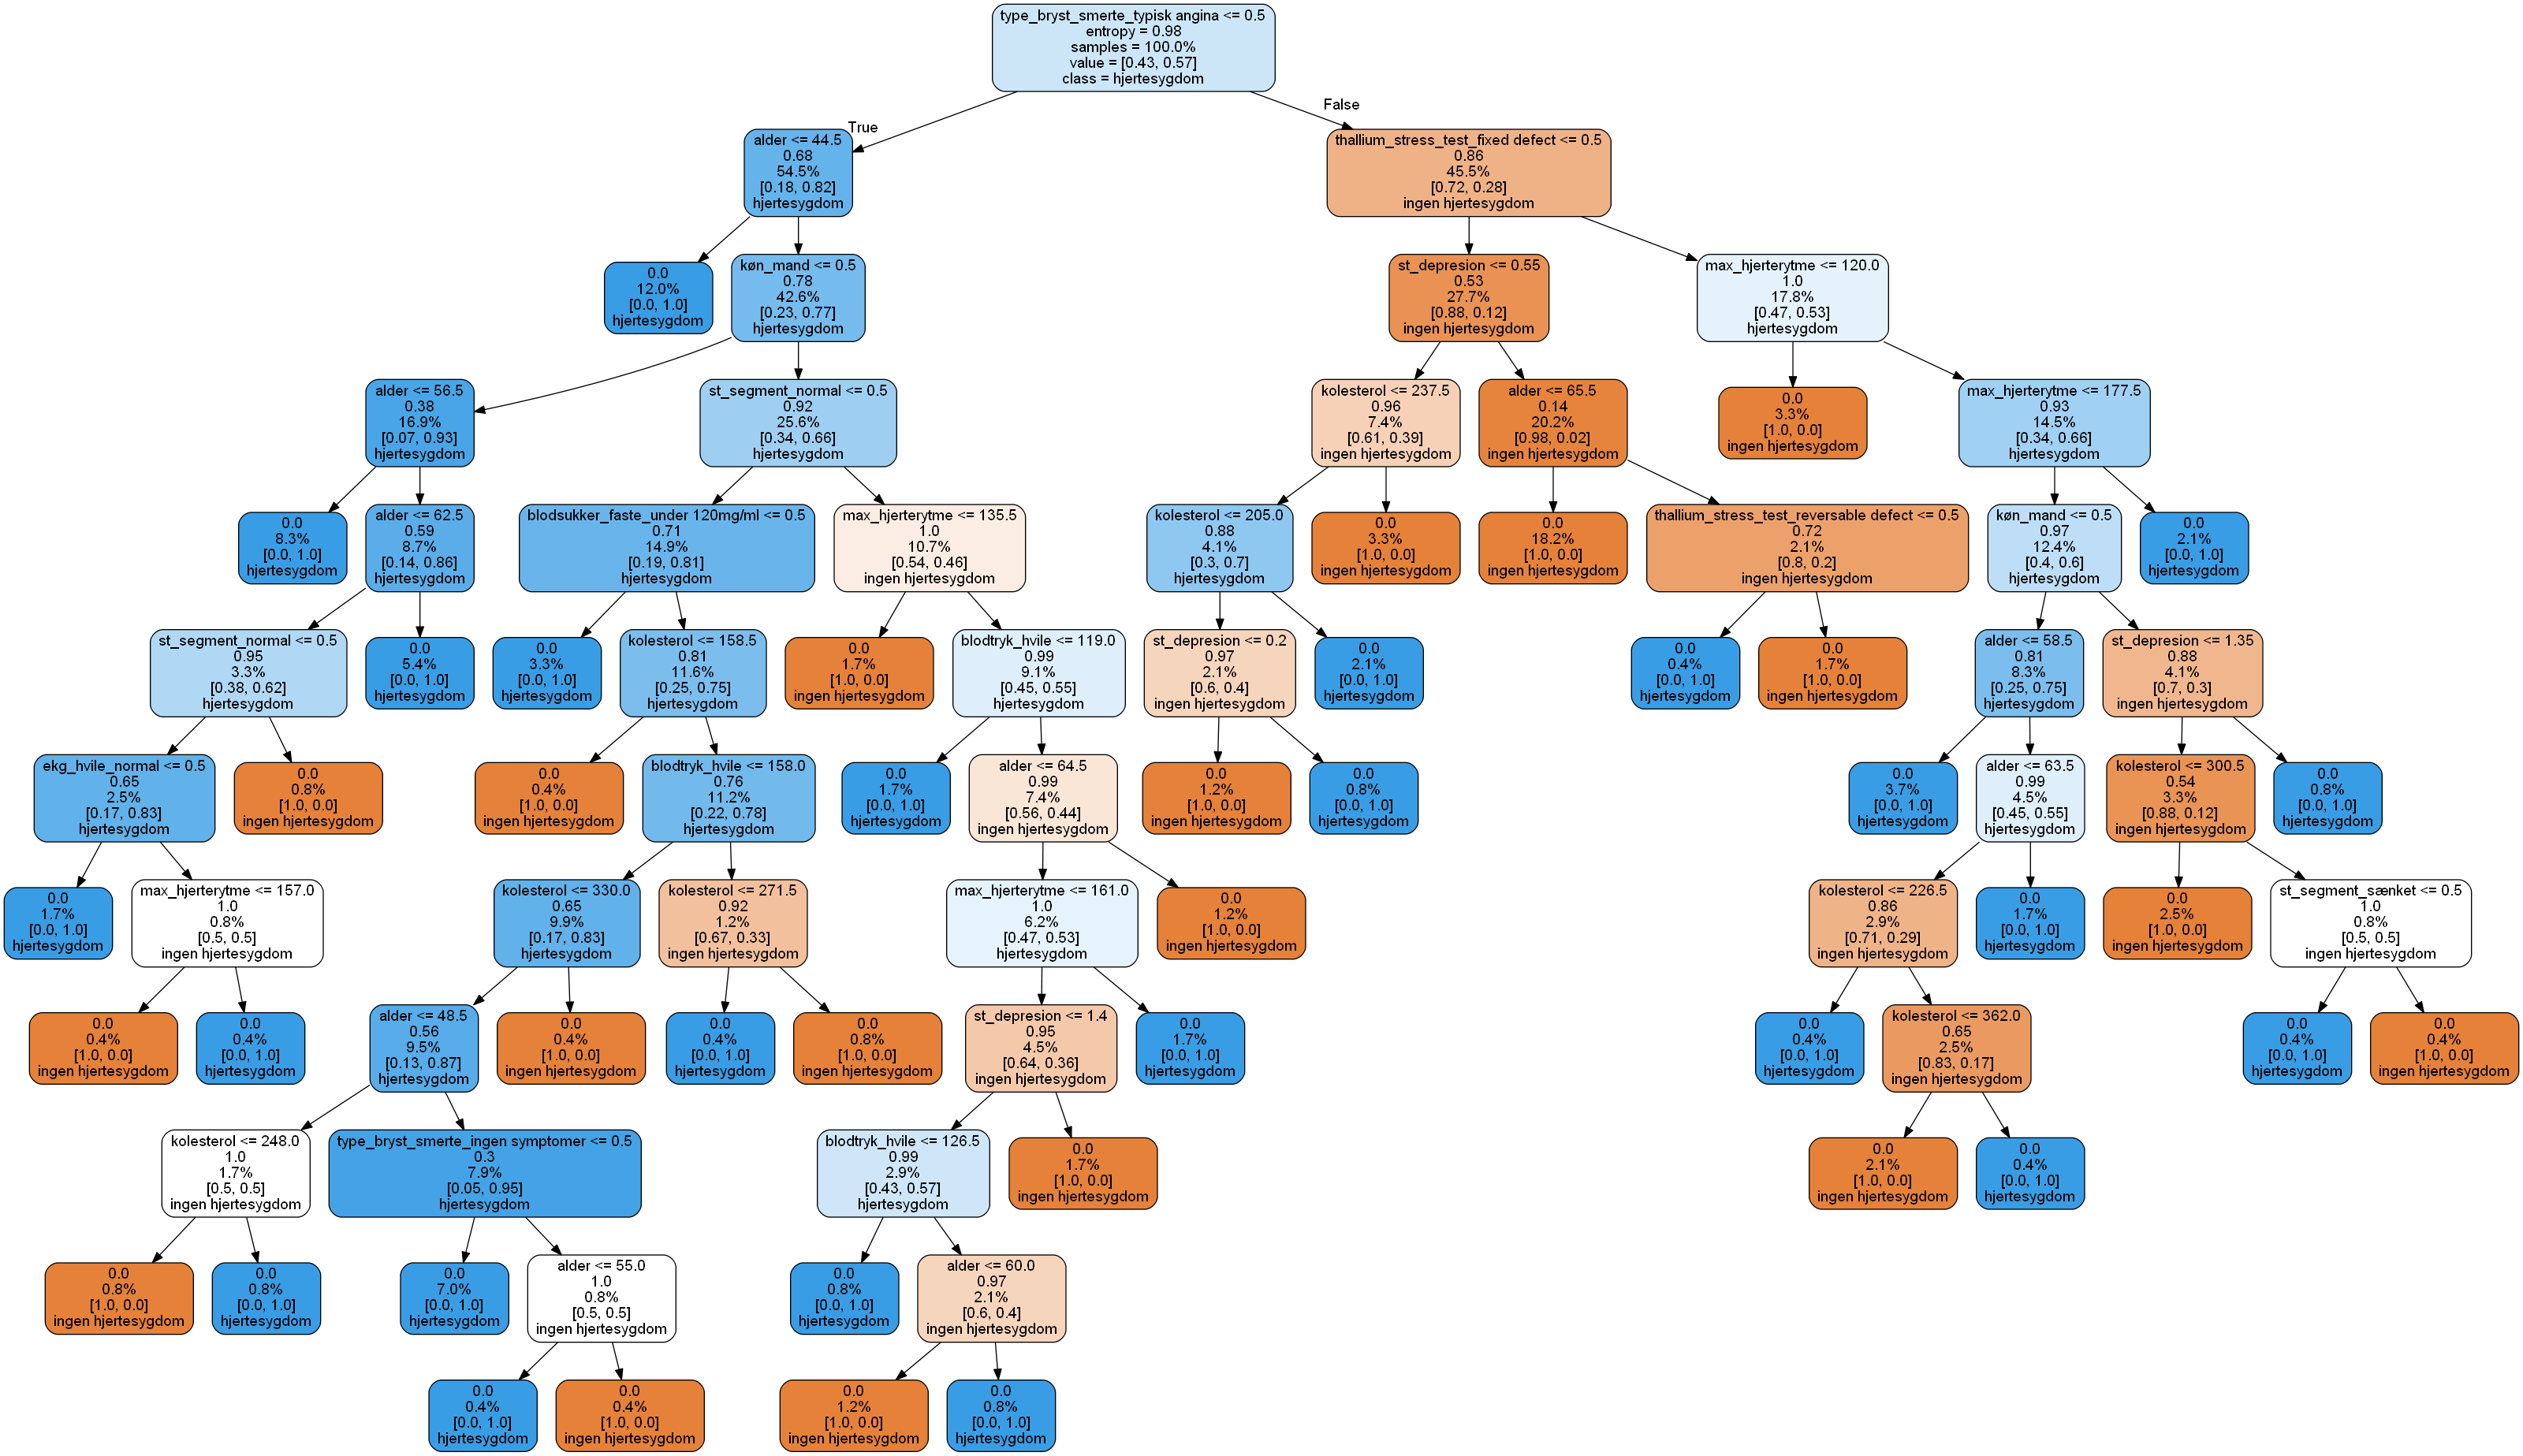

In [50]:
#os importeres for at hjælpe python med at finde GraphViz: https://stackoverflow.com/questions/40632486/dot-exe-not-found-in-path-pydot-on-python-windows-7
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

#exportere til Graphviz - Graphvis skal downloades og installeres seperat fra python for at kunne håndtere dot filer
export_graphviz(estimator, out_file='tree1.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root',
                precision = 2, filled = True)

#Gør det samme som subprocess hvis det ellers gad virke -,-
import pydot
(graph,) = pydot.graph_from_dot_file('tree1.dot')
graph.write_png('tree1.png')

#from subprocess import call
#call(['dot', '-Tpng', 'tree1.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree1.png')

In [51]:
y_predict = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)[:, 1]
y_pred_bin = model.predict(X_test)

In [52]:
confusion_matrix = confusion_matrix(y_test, y_pred_bin)
confusion_matrix

array([[25, 10],
       [ 6, 20]], dtype=int64)

Vi bruger sensitivity og specificity som mål for modellens præcision
<br>
Sensitivity: True positives - mængden af korrekt forudsagt positives (patienter med hjertesygdomme) 
<br>
Specificity: True negatives - korrekt forudsagt negativer (patienter uden hjertesygdomme)
<br>
<br>
Edit - tilføjet Accuracy, Mis-classifications og Precision
<br>
Accuracy: % del af korrekt forudsigelser
<br>
Mis-classifications: forkerte forudsigelser
<br>


In [53]:
#Funktioner til udregning af sensitivt og specificity 
#https://towardsdatascience.com/evaluating-machine-learning-classification-problems-in-python-5-1-metrics-that-matter-792c6faddf5
TP = confusion_matrix[1][1]
TN = confusion_matrix[0][0]
FP = confusion_matrix[0][1]
FN = confusion_matrix[1][0]

# calculate accuracy
conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
# calculate mis-classification
conf_misclassification = 1- conf_accuracy
# calculate the sensitivity
conf_sensitivity = (TP / float(TP + FN))
# calculate the specificity
conf_specificity = (TN / float(TN + FP))
# calculate precision
conf_precision = (TN / float(TN + FP))

print('Accuracy: ', conf_accuracy)
print('Mis-classification: ', conf_misclassification)
print('Sensitivity: ',conf_sensitivity)
print('Specificity: ', conf_specificity)

Accuracy:  0.7377049180327869
Mis-classification:  0.2622950819672131
Sensitivity:  0.7692307692307693
Specificity:  0.7142857142857143


In [54]:
#######Denne udregning er forkert###########
#fix later

#total=sum(sum(confusion_matrix))
#sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
#print('Sensitivity : ', sensitivity_score(confusion_matrix[0,0,]confusion_matrix[1,0]) )

#specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
#print('Specificity : ', specificity_score(y_test, y_pred_bin))

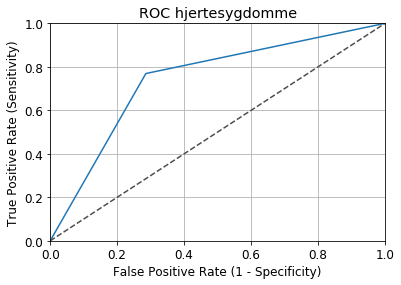

In [55]:
#Roc curve er en visualisering af ovenstående
#Dokumentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
#Wiki: https://en.wikipedia.org/wiki/Receiver_operating_characteristic

fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC hjertesygdomme')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

Ud fra ovenstående ROC kan man udarbejde en AUC analyse (Area Under the Curve)
<br>
Machine Learning algoritmer sælges ofte som AUC som et hovede målepunkt for algoritmens præcision
<br>
wiki https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
<br>
Tommefinger regl for AUC:
<br>
0.90 - 1.00 = excellent
<br>
0.80 - 0.90 = good
<br>
0.70 - 0.80 = fair
<br>
0.60 - 0.70 = poor
<br>
0.50 - 0.60 = fail
<br>
"Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. By analogy, Higher the AUC, better the model is at distinguishing between patients with disease and no disease." https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5
<br>

In [56]:
auc(fpr, tpr)

0.7417582417582418

Ud fra den udregnet AUC kan det ses at algortimen er god til at differentiere patineter med og uden sygdom (dette har ikke noget med pæcision at gøre)
<br>
Det skal dog nævnes at AUC har nogle problemstillinger forbundet med sig, som gør at nogle mener det er et dårligt measure.
<br>
Det kan læses om her: https://www.kdnuggets.com/2010/09/pub-is-auc-the-best-measure.html

In [57]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0918 ± 0.0608,type_bryst_smerte_typisk angina
0.0557 ± 0.0736,thallium_stress_test_fixed defect
0.0459 ± 0.0482,køn_mand
0.0426 ± 0.0765,alder
0.0262 ± 0.0608,max_hjerterytme
0.0230 ± 0.0491,st_segment_normal
0.0131 ± 0.0131,blodsukker_faste_under 120mg/ml
0 ± 0.0000,thallium_stress_test_normal
0 ± 0.0000,blodtryk_hvile
0 ± 0.0000,thallium_stress_test_reversable defect


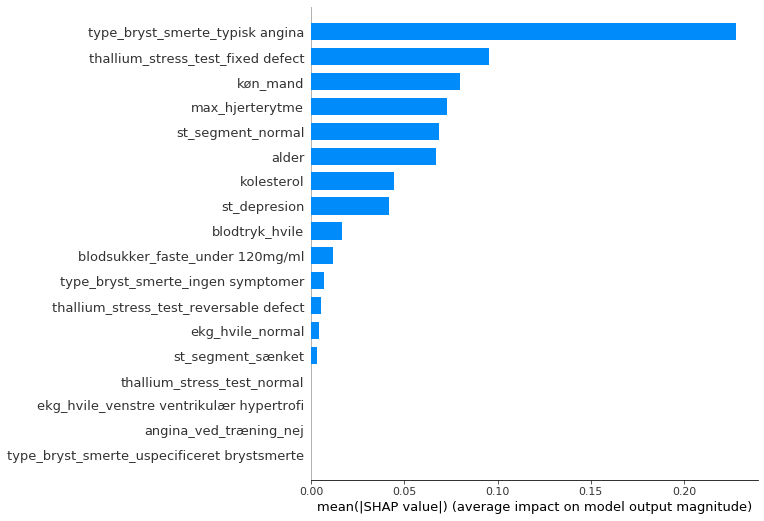

In [58]:
#Explainer bruges til at forkalre hvilken impact forskellige features har på modellen
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")

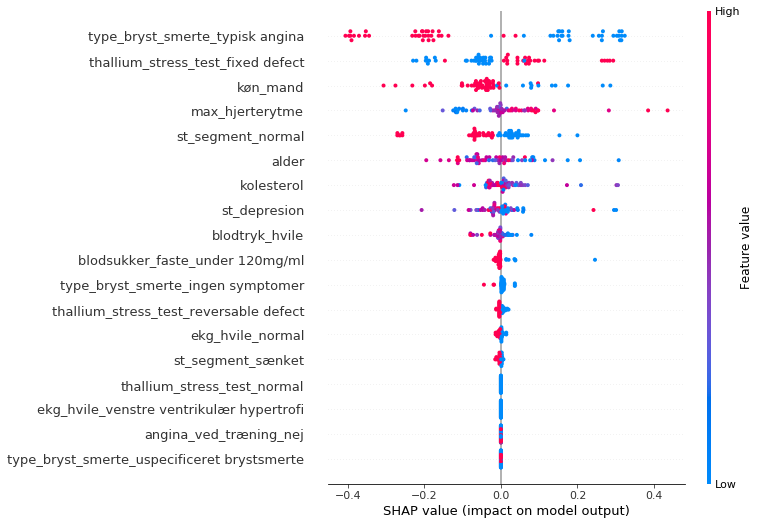

In [59]:
#Visualisering af hvordan features påvirker værdien
shap.summary_plot(shap_values[1], X_test)

Positiv = Hjertesygdom
<br>
Negativ = Ingen hjertesygdom
<br>
Man ser at antallet af blodkar der er blevet farvet i en fluroskopi har den største indflydelse på modellen. Dette er i virkligheden problematisk, da dette ikke har en direkte forbindelse med hjertesygdom, men er en del af den undersøgelse patienten har været igennem. For at model der kan forudsige hjertesygdomme før patienten er blevet undersøgt bør denne udtages.
<br>
<br>
Det ses også at agina ved træning har en høj indflydelse. Dog ikke som forventet da den hælder til at svaret "nej" til agina ved træning giver en større sandsynlighed for at have en hjertesygdom.
<br>
Køn spiller også en stor rolle, men igen modsat af hvad man forventer. I følge modellen har kvinder større sandsynlighed for at få en hertesygdom end mænd. En hurtigt google søgning fortæller os at mænd har højere risiko for at få en hjertesygdom.
Dette kan forklares med at det er et meget lille datasæt og at der er flere kviner med hjertesygdomme i sættet end mænd.

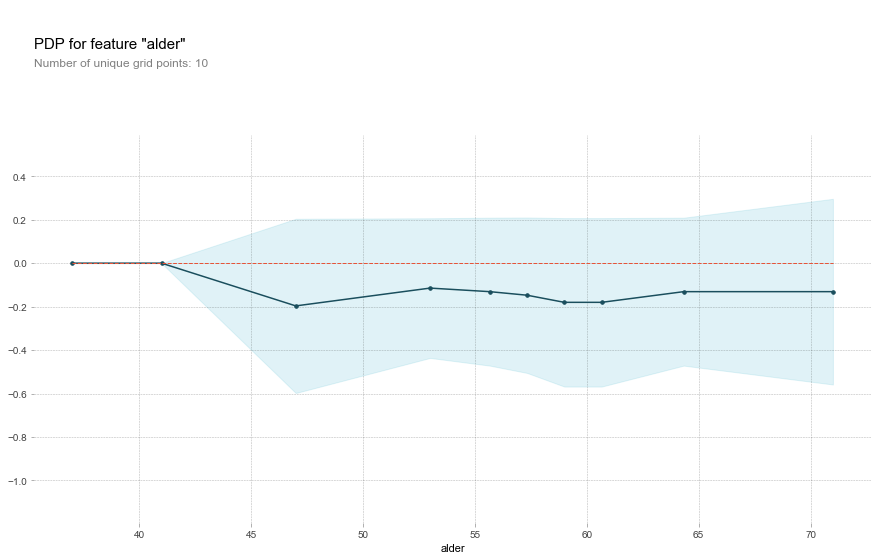

In [60]:
#Et nærmere kig på flere features
base_features = dt.columns.values.tolist()
base_features.remove('target')
#Alder
#feature_name = 'blodkar_fluoroskopi'
feature_name = 'alder'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feature_name)

pdp.pdp_plot(pdp_dist, feature_name)
plt.show()

Modellen forudsiger at en højere alder er giver en lavere chance for at have en hjertesygdom.
Forklaring kan ligge i at datasættet ikke repræsentere en stor nok målgruppe og de få "unge" der er med har tilfældigvis en hjertesygdom.

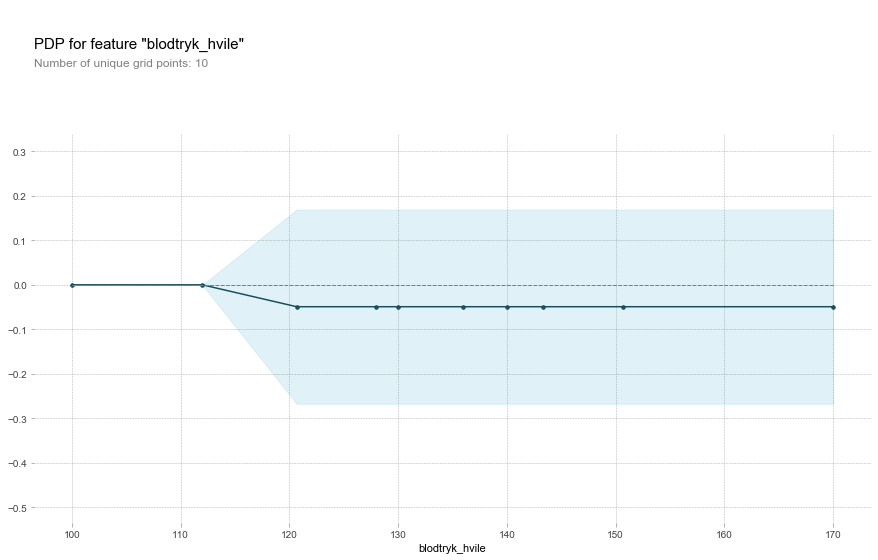

In [61]:
#blodsukker hvile
feat_name = 'blodtryk_hvile'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

Modellen forudsiger også at et højre hvile blodtryk giver er lavere chance for at have en hjerte sygdom, dette virker også modsat af hvad man ville forvente.

In [62]:
#Vi kigger på de individuelle patinenter
#Funktionen er lavet til shap.TreeExplainer og bruges til at kigge ned i individuelle data punkter
#Funktionen har to input model og patient, model er selve DecissionTree fra tidligere og patient er en float
def heart_disease_risk_factors(model, patient):

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient)

In [63]:
#iloc er en Pandas funktion som bruges til at udvælge n række i en et pandas dataframe
data_for_prediction = X_test.iloc[1,:].astype(float)
heart_disease_risk_factors(model, data_for_prediction)

Base value viser den base værdi modellen har for sine forudsigelser - altså er den er base sandsynlighed på 57 for at have en hjertesygdom.
<br>
Output value viser modellens forudsigelse for hvor stor sandsynlig patienten har for at have en hjerte sygdom.
<br>
Grafen skal læses som at de ting der er på venstre side "skubber" sandsynligheden mod højre. 

In [64]:
#Plottet viualisere alle patienter i test sættet (50) og hvilke features der har påvirket deres vurdering
#Plottet er desuden interaktiv så man kan dykke ned i bestemte features
#Rød: forudsigelse = hjertesygdom
#Blå: forudsigelse = ingen sygdom

shap_values = explainer.shap_values(X_train.iloc[:50])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[:50])